In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [45]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df.head()

,Date,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
0,1993-01-29 00:00:00,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1,1993-02-01 00:00:00,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
2,1993-02-02 00:00:00,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
3,1993-02-03 00:00:00,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
4,1993-02-04 00:00:00,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [46]:
log_ret_100x = 100 * (df['Log Return'].dropna() - df['Log Return'].dropna().mean()).reset_index(drop=True)

In [53]:
returns = np.array(log_ret_100x[-2000:])

In [56]:
betas = initialize_betas(returns, n=1000, m=10)

In [57]:
betas

[{'loss': 757.9706945846904,
  'beta': array([0.00945801, 0.45767256, 0.02787627, 0.27997814])},
 {'loss': 758.3464549921638,
  'beta': array([0.04356074, 0.06856659, 0.02229334, 0.33521124])},
 {'loss': 758.3679640840822,
  'beta': array([0.0163062 , 0.10517646, 0.04424806, 0.00792445])},
 {'loss': 760.0548434882917,
  'beta': array([0.02201972, 0.69165416, 0.01814776, 0.26183346])},
 {'loss': 766.7583783425619,
  'beta': array([0.0415094 , 0.51687817, 0.06848729, 0.87910629])},
 {'loss': 769.4407017074499,
  'beta': array([0.00150438, 0.67464233, 0.12348359, 0.24535134])},
 {'loss': 773.5839465518716,
  'beta': array([0.01367957, 0.18240731, 0.15982512, 0.80127409])},
 {'loss': 776.4987687899102,
  'beta': array([0.14317561, 0.14376127, 0.07372389, 0.33802223])},
 {'loss': 779.8695019944882,
  'beta': array([0.06661839, 0.46691186, 0.12910607, 0.64347537])}]

In [70]:
beta = optimize(betas, tol=1e-10)

<ipython-input-66-658e2b38378d>:14: RuntimeWarning: overflow encountered in double_scalars
  sigmas[t] = b1 + b2 * sigmas[t-1] + max(b3 * returns[t-1], 0) + b4 * min(b3 * returns[t-1], 0)


In [71]:
sigmas = asymmetric_slope(returns, beta)

In [79]:
plt_returns = log_ret_100x[-2000:]

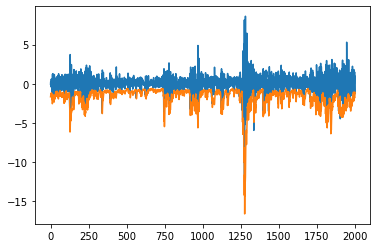

In [84]:
plt.plot(returns)
plt.plot(sigmas)

In [77]:
np.sum(returns<=sigmas)/2000

0.05

In [66]:
def get_empirical_quantile(returns, until_first=300, quantile=0.05):
    return np.quantile(returns[:until_first], quantile)

def asymmetric_slope(returns, betas):
    """
    :param: returns (array): a series of daily returns
    :param: betas (array): a series of coefficients
    :returns: VaR
    """
    b1, b2, b3, b4 = betas
    sigmas = np.zeros_like(returns)
    sigmas[0] = get_empirical_quantile(returns) # np.std(returns) # im not sure
    for t in range(1, len(sigmas)):
        sigmas[t] = b1 + b2 * sigmas[t-1] + max(b3 * returns[t-1], 0) + b4 * min(b3 * returns[t-1], 0)
    return sigmas

In [67]:
def obj(betas, returns, quantile=0.05):
    sigmas = asymmetric_slope(returns, betas)
    dev = returns - sigmas
    e = np.where(dev<0, (quantile - 1) * dev, quantile * dev)
    return np.sum(e)

In [68]:
def initialize_betas(returns, n=1000, m=10):
    """
    :param: n (int): We generated n vectors using a uniform random number generator between 0 and 1.
    :param: m (int): We computed the regression quantile (RQ) function for each of these vectors and
                     selected the m vectors that produced the lowest RQ criterion as initial values
                     for the optimization routine
    """
    betas = np.random.uniform(0, 1, (n, 4))

    best_initial_betas = []

    for i in range(n):
        loss = obj(betas[i], returns)

        best_initial_betas.append(
            {'loss': loss, 'beta': betas[i]}
        )

        best_initial_betas = sorted(best_initial_betas, key=lambda x: x['loss'])

        if len(best_initial_betas)==m:
               best_initial_betas.pop()
    
    return best_initial_betas

In [69]:
def initialize_betas(returns, n=1000, m=10):
    """
    :param: n (int): We generated n vectors using a uniform random number generator between 0 and 1.
    :param: m (int): We computed the regression quantile (RQ) function for each of these vectors and
                     selected the m vectors that produced the lowest RQ criterion as initial values
                     for the optimization routine
    """
    betas = np.random.uniform(0, 1, (n, 4))

    best_initial_betas = []

    for i in range(n):
        loss = obj(betas[i], returns)

        best_initial_betas.append(
            {'loss': loss, 'beta': betas[i]}
        )

        best_initial_betas = sorted(best_initial_betas, key=lambda x: x['loss'])

        if len(best_initial_betas)==m:
               best_initial_betas.pop()
    
    return best_initial_betas
def optimize(initial_beta, tol=1e-10):
    beta_new = initial_beta['beta']
    current_loss = initial_beta['loss']

    while True:
        # Minimize the function using the Nelder-Mead algorithm
        res = minimize(obj, beta_new, args=(returns, ), method='Nelder-Mead')
        beta_new = res.x

        loss = res.fun

        if current_loss - loss < tol:
            break
        else:
            current_loss = loss

        # Minimize the function using the BFGS algorithm
        res = minimize(obj, beta_new, args=(returns, ), method='BFGS')
        beta_new = res.x

        loss = res.fun

        if current_loss - loss < tol:
            break
        else:
            current_loss = loss
    
    return beta_new

In [27]:
for i in range(100):
    loss = obj(betas[i], returns)
    
    best_10.append(
        {'loss': loss, 'beta': betas[i]}
    )
    
    best_10 = sorted(best_10, key=lambda x: x['loss'])
    
    if len(best_10)==10:
           best_10.pop()

In [40]:
tol = 1e-10

beta_new = best_10[0]['beta']
current_loss = best_10[0]['loss']

while True:
    # Minimize the function using the Nelder-Mead algorithm
    res = minimize(obj, beta_new, args=(returns, ), method='Nelder-Mead')
    beta_new = res.x
    
    loss = res.fun
    
    if current_loss - loss < tol:
        break
    else:
        current_loss = loss

    # Minimize the function using the BFGS algorithm
    res = minimize(obj, beta_new, args=(returns, ), method='BFGS')
    beta_new = res.x
    
    loss = res.fun
    
    if current_loss - loss < tol:
        break
    else:
        current_loss = loss

In [ ]:
class CaviarModel:
    def __init__(self, quantile, model='asymmetric'):
        """
        :param: quantile (float): between 0 and 1 exclusively
        :param: model (str): type of CAViaR model
        :param: G (int): some positive number for the smoothen version of indicator function
        """
        if quantile > 0 and quantile < 1:
            self.quantile = quantile
        else:
            raise ValueError('Quantile must be within 0, 1 exclusively.')
        
        if model in ['adaptive', 'symmetric', 'asymmetric', 'igarch']:
            self.model = model
        else:
            raise ValueError('Model must be one of {"adaptive", "symmetric", "asymmetric", "igarch"}')
        


    def neg_log_likelihood(self, params, returns, caviar_func):
        """
        :param: returns (array): a series of daily returns
        :param: betas (array): a series of coefficients
        :param: caviar_func (callable function): a CAViaR function that returns VaR
        :returns: negative log likelihood
        """
        T = len(returns)
        
        tau = params[0]
        betas = params[1:]

        sigmas = caviar_func(returns, betas)

        llh = (1 - T) * np.log(tau)
        for t in range(1, T):
            llh -= 1 / tau * max((self.quantile - 1) * (returns[t] - sigmas[t]),
                                 self.quantile * (returns[t] - sigmas[t]))

        return -llh
    
